# Notebook 2: Data preprocessing

Table of contents: 



## Configuration de l'environnement

In [241]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import chi2_contingency

# Sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

## Parameters

In [242]:
# Set random seed for reproducibility
R_seed = 42
np.random.seed(R_seed)

# Data path
data_path = 'data/Loan_data.csv'
data_description_path = 'data/Dictionnaire_des_données.xlsx'

## Utility functions

In [243]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

## Data Preprocessing

In [244]:
df = pd.read_csv(data_path)
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [245]:
df = df.drop('ApplicationDate', axis=1)
df = df.drop('LoanApproved', axis=1)

variables_na = []
variables_numeriques = []
variables_01 = []
variables_categorielles = []
for colu in df.columns:
    if True in df[colu].isna().unique() :
        variables_na.append(df[colu])
    else :
        if str(df[colu].dtypes) in ["int32","int64","float64"]:
            if len(df[colu].unique())==2 :
                variables_categorielles.append(df[colu])
            else :
                variables_numeriques.append(df[colu])
        else :
            if len(df[colu].unique())==2 :
                variables_categorielles.append(df[colu])
            else :
                variables_categorielles.append(df[colu])

In [246]:
len(variables_numeriques)+len(variables_categorielles) == df.shape[1]

True

## Correlation between categorical variables

In [247]:
vars_categorielles = pd.DataFrame(variables_categorielles).transpose()
vars_categorielles = vars_categorielles.reindex(sorted(vars_categorielles.columns), axis=1)

rows= []
for var1 in vars_categorielles:
  col = []
  for var2 in vars_categorielles :
    cramers =cramers_V(vars_categorielles[var1], vars_categorielles[var2]) # V de Cramer
    col.append(round(cramers,2)) # arrondi du résultat   
  rows.append(col)

cramers_results = np.array(rows)
v_cramer_resultats = pd.DataFrame(cramers_results, columns = vars_categorielles.columns, 
                                  index =vars_categorielles.columns)
v_cramer_resultats

,BankruptcyHistory,EducationLevel,EmploymentStatus,HomeOwnershipStatus,LoanPurpose,MaritalStatus,PreviousLoanDefaults
BankruptcyHistory,1.0,0.00,0.00,0.0,0.0,0.0,0.0
EducationLevel,0.0,1.00,0.01,0.0,0.0,0.0,0.0
EmploymentStatus,0.0,0.01,1.00,0.0,0.0,0.0,0.0
HomeOwnershipStatus,0.0,0.00,0.00,1.0,0.0,0.0,0.0
LoanPurpose,0.0,0.00,0.00,0.0,1.0,0.0,0.0
MaritalStatus,0.0,0.00,0.00,0.0,0.0,1.0,0.0
PreviousLoanDefaults,0.0,0.00,0.00,0.0,0.0,0.0,1.0


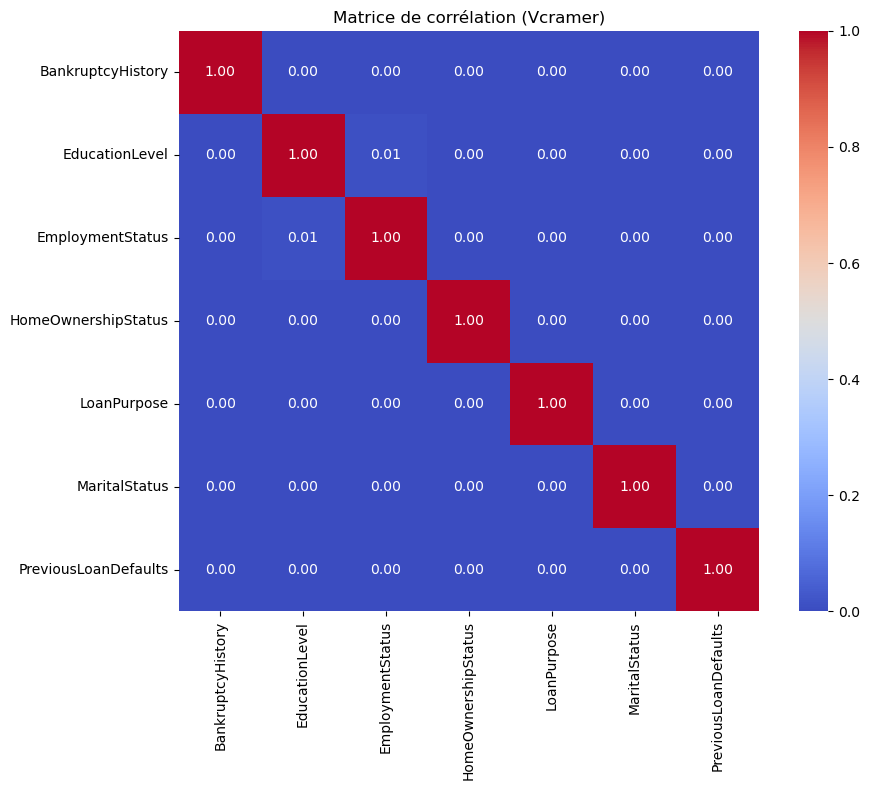

In [248]:
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(v_cramer_resultats, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matrice de corrélation (Vcramer)')
plt.tight_layout()
plt.show()

In [249]:
#On repère les variables trop corrélées
for i in range(v_cramer_resultats.shape[0]):
  for j in range(i+1,v_cramer_resultats.shape[0]) :
    if v_cramer_resultats.iloc[i,j] > 0.7 :
        print(v_cramer_resultats.index.to_numpy()[i]+" et "+ v_cramer_resultats.columns[j] 
              + " sont trop dépendantes, V-CRAMER = " + str(v_cramer_resultats.iloc[i,j]))

## Correlation between numerical variables

In [250]:
vars_numeriques = pd.DataFrame(variables_numeriques).transpose()
vars_numeriques = vars_numeriques.reindex(sorted(vars_numeriques.columns), axis=1)
#Corrélation de Pearson
correlations_num = vars_numeriques.corr(method='pearson')
correlations_num 

,Age,AnnualIncome,BaseInterestRate,CheckingAccountBalance,CreditCardUtilizationRate,CreditScore,DebtToIncomeRatio,Experience,InterestRate,JobTenure,...,NumberOfCreditInquiries,NumberOfDependents,NumberOfOpenCreditLines,PaymentHistory,RiskScore,SavingsAccountBalance,TotalAssets,TotalDebtToIncomeRatio,TotalLiabilities,UtilityBillsPaymentHistory
Age,1.000000,0.144774,-0.238995,0.010145,-0.001394,0.323243,0.004438,0.982980,-0.202702,-0.000773,...,-0.002165,-0.000287,-0.001069,-0.002487,-0.164304,0.004236,0.012210,-0.111800,-0.001197,-0.005601
AnnualIncome,0.144774,1.000000,-0.074549,0.008613,-0.007935,0.104045,0.001507,0.145999,-0.063832,-0.000610,...,-0.005016,-0.001244,-0.008175,0.003715,-0.483289,-0.001397,-0.005158,-0.532033,-0.002353,-0.012351
BaseInterestRate,-0.238995,-0.074549,1.000000,-0.003554,0.003668,-0.722619,-0.003888,-0.242871,0.834557,-0.001661,...,-0.000409,0.006977,0.007457,-0.002999,0.256233,0.006012,-0.007368,0.131853,0.007140,-0.005517
CheckingAccountBalance,0.010145,0.008613,-0.003554,1.000000,-0.002115,0.005515,0.002561,0.009292,-0.001943,-0.002440,...,-0.004238,0.002485,-0.005282,-0.017384,-0.004044,-0.000392,0.003322,-0.006630,0.001473,-0.005696
CreditCardUtilizationRate,-0.001394,-0.007935,0.003668,-0.002115,1.000000,-0.009650,0.002231,-0.001751,0.001030,-0.006979,...,0.001708,0.011544,0.001491,0.004517,0.108758,0.004026,-0.005047,0.010490,-0.007778,0.013040
CreditScore,0.323243,0.104045,-0.722619,0.005515,-0.009650,1.000000,0.001913,0.327664,-0.598844,0.008069,...,-0.001928,-0.014453,-0.008780,0.004295,-0.240198,-0.006316,0.001342,-0.115363,-0.006722,-0.006838
DebtToIncomeRatio,0.004438,0.001507,-0.003888,0.002561,0.002231,0.001913,1.000000,0.003139,-0.006106,0.009165,...,0.005453,-0.007981,0.004363,-0.006869,0.326500,-0.004453,-0.007662,-0.013076,-0.002644,-0.014412
Experience,0.982980,0.145999,-0.242871,0.009292,-0.001751,0.327664,0.003139,1.000000,-0.206252,-0.000762,...,-0.002905,0.000136,-0.002143,-0.003346,-0.166496,0.005876,0.013074,-0.112825,-0.000449,-0.006603
InterestRate,-0.202702,-0.063832,0.834557,-0.001943,0.001030,-0.598844,-0.006106,-0.206252,1.000000,-0.004422,...,-0.005468,0.006749,0.008090,0.002030,0.268203,0.002731,-0.005807,0.131765,0.010176,-0.004051
JobTenure,-0.000773,-0.000610,-0.001661,-0.002440,-0.006979,0.008069,0.009165,-0.000762,-0.004422,1.000000,...,0.002794,0.010910,0.007298,-0.007882,-0.004393,-0.004250,0.007057,0.005206,-0.003399,-0.007986


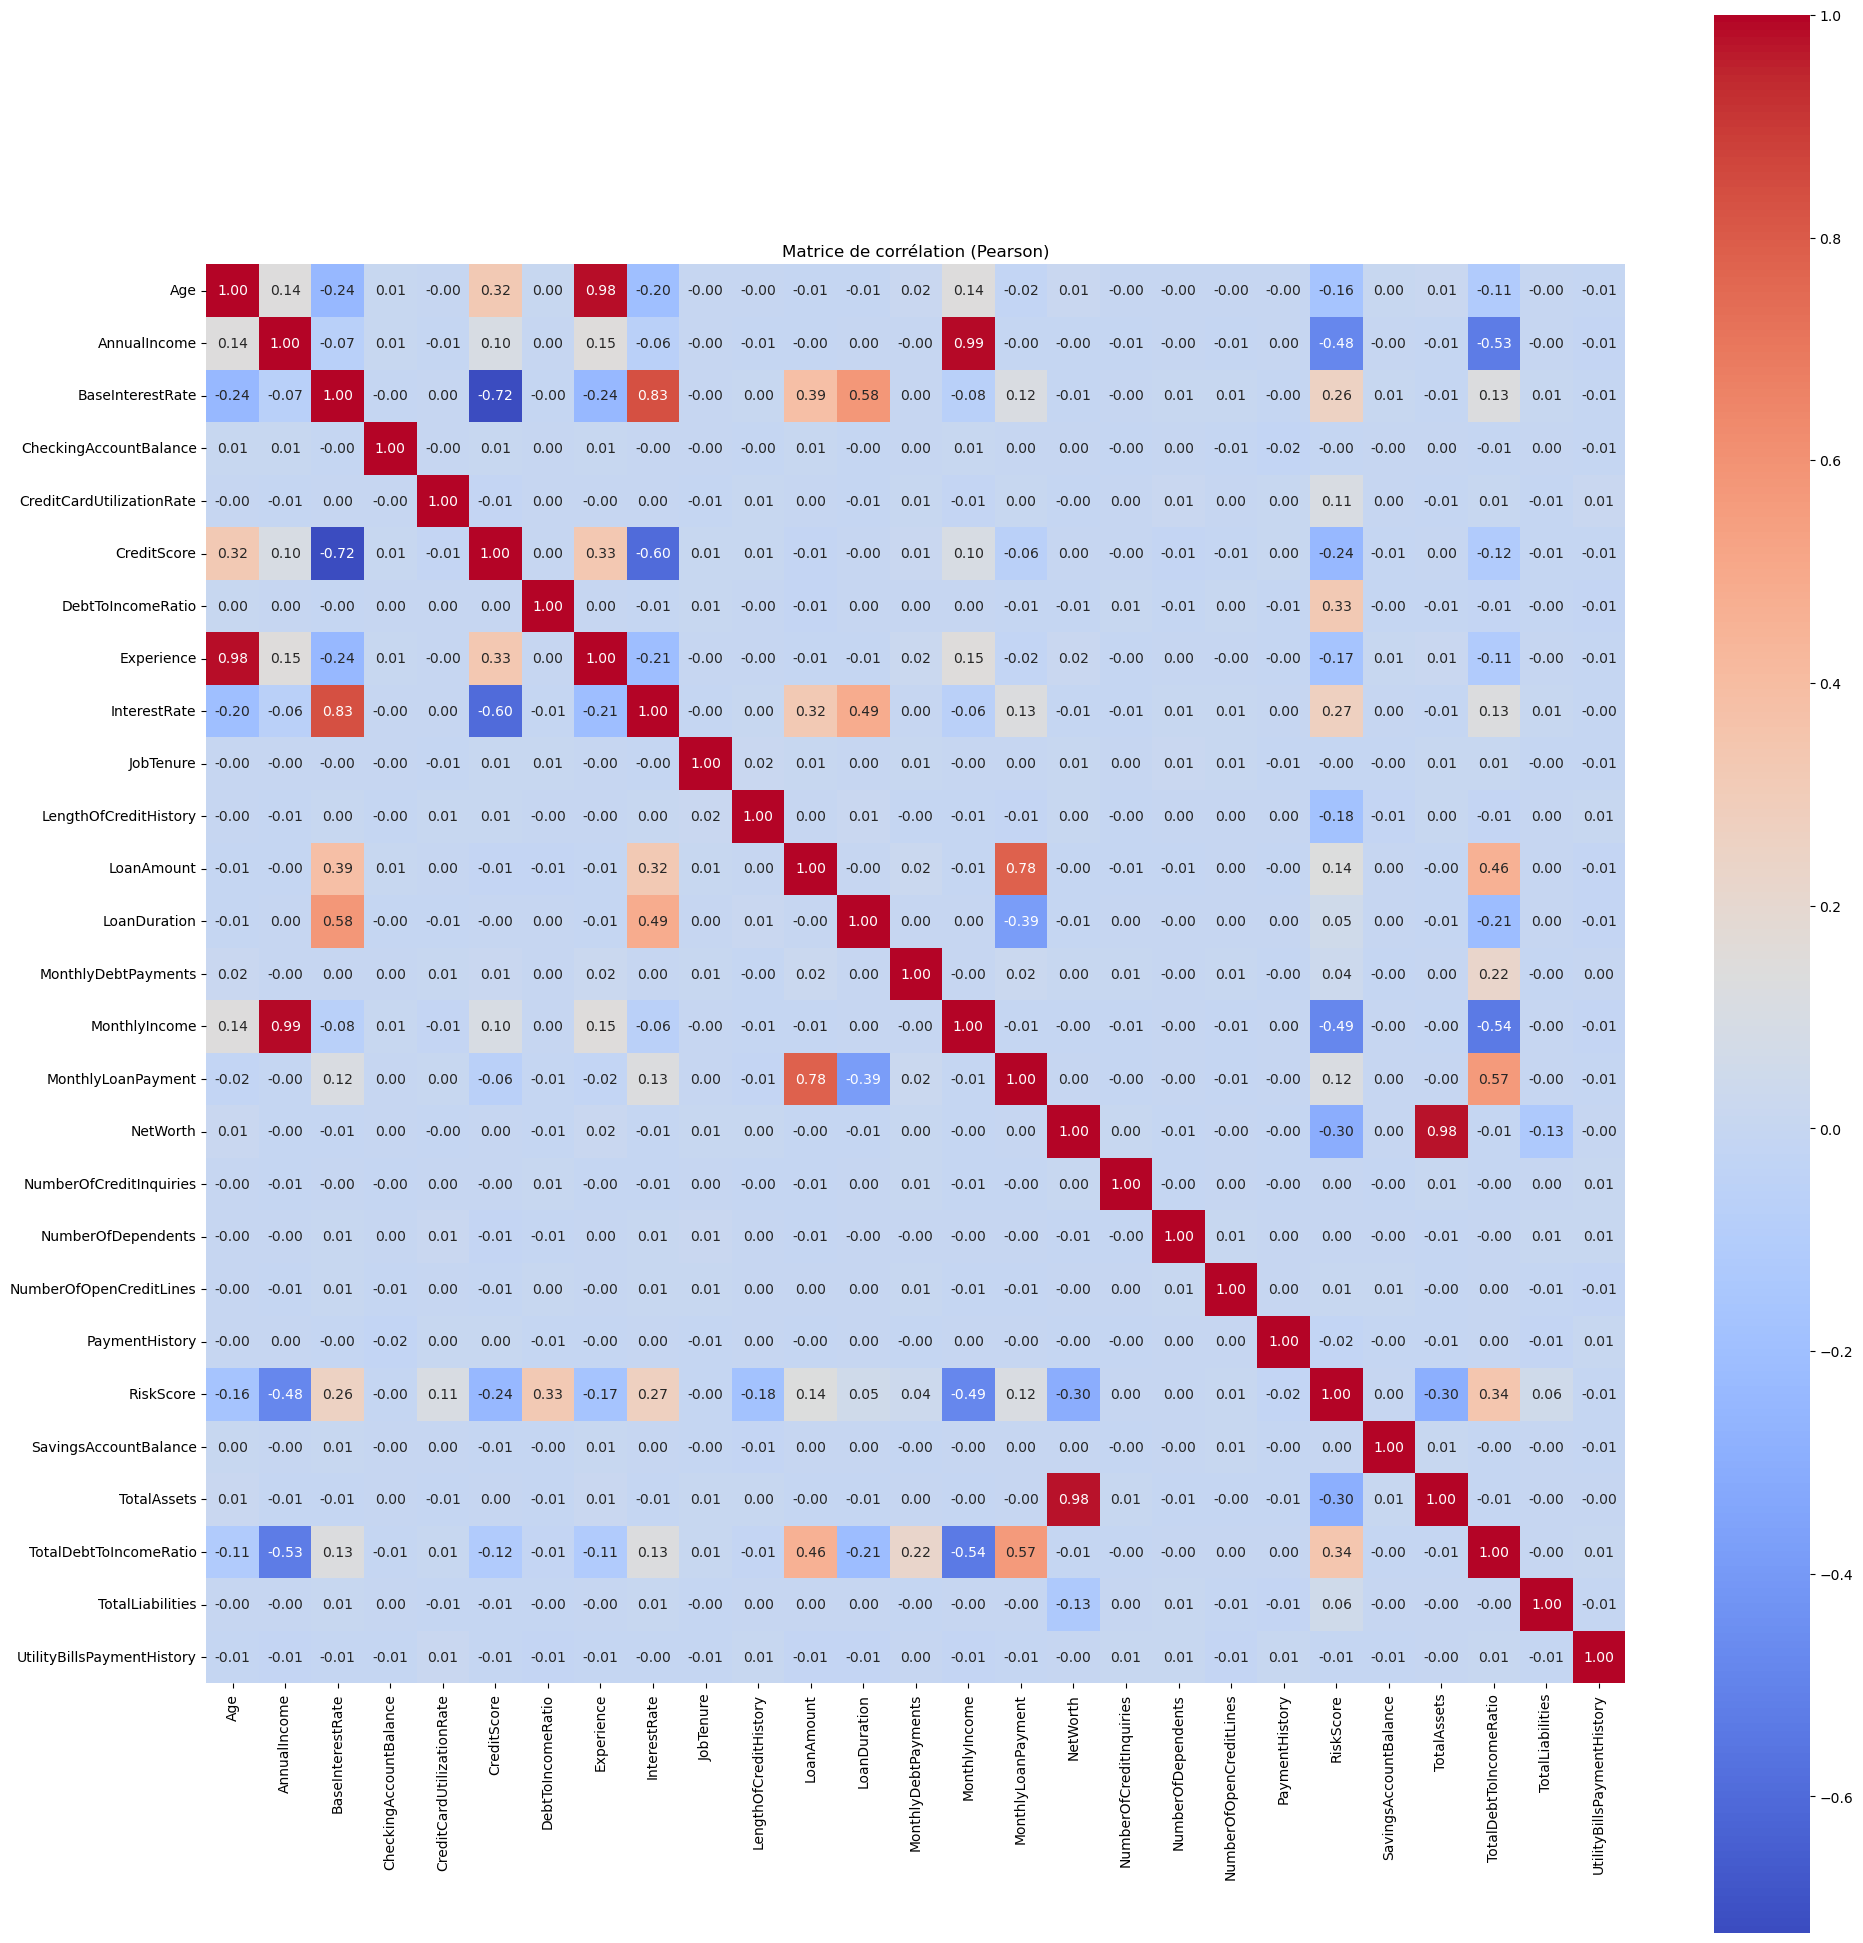

In [251]:
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlations_num, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matrice de corrélation (Pearson)')
plt.tight_layout()
plt.show()

In [252]:
#On repère les variables trop corrélées
nb_variables = correlations_num.shape[0]
for i in range(nb_variables):
  for j in range(i+1,nb_variables) :
    if abs(correlations_num.iloc[i,j]) > 0.7 :
        print("\n",correlations_num.index.to_numpy()[i]+" et "+
              correlations_num.columns[j] + " sont trop dépendantes, corr = " + str(correlations_num.iloc[i,j]))


 Age et Experience sont trop dépendantes, corr = 0.9829802792421133

 AnnualIncome et MonthlyIncome sont trop dépendantes, corr = 0.9899107753669869

 BaseInterestRate et CreditScore sont trop dépendantes, corr = -0.7226185591437013

 BaseInterestRate et InterestRate sont trop dépendantes, corr = 0.8345565713776919

 LoanAmount et MonthlyLoanPayment sont trop dépendantes, corr = 0.7808278281607225

 NetWorth et TotalAssets sont trop dépendantes, corr = 0.978996695445731


## VIF computation for numeric variables

In [253]:
# we dont take into account the target variable "RiskScore" for vif computation
vars_VIF = vars_numeriques.copy()

vars_VIF.drop(["RiskScore"], axis = 1, inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vars_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(vars_VIF.values, i) for i in range(vars_VIF.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                       feature         VIF
2             BaseInterestRate  201.677527
5                  CreditScore  108.813423
14               MonthlyIncome   50.689087
1                 AnnualIncome   49.848380
16                    NetWorth   40.481851
22                 TotalAssets   39.799417
7                   Experience   29.762531
0                          Age   29.650505
11                  LoanAmount   16.555441
12                LoanDuration   15.968864
15          MonthlyLoanPayment    5.024680
8                 InterestRate    3.339839
23      TotalDebtToIncomeRatio    2.892992
24            TotalLiabilities    1.681355
13         MonthlyDebtPayments    1.128563
25  UtilityBillsPaymentHistory    1.001704
20              PaymentHistory    1.001331
21       SavingsAccountBalance    1.001159
9                    JobTenure    1.001090
10       LengthOfCreditHistory    1.001043
6            DebtToIncomeRatio    1.001026
18          NumberOfDependents    1.001016
4    Credit

## Drop highly collinear/correlated variables

We decided to drop the variable "BaseInterestRate" because it has a very high VIF value (above 10), indicating strong multicollinearity with other variables. Moreover, it was already highly correlated with the variable "InterestRate". Removing this variable helps to improve the stability and interpretability of our regression models.

In [254]:
vars_VIF.drop(["BaseInterestRate"], axis = 1, inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vars_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(vars_VIF.values, i) for i in range(vars_VIF.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)


                       feature         VIF
0                          Age  322.432623
13               MonthlyIncome  162.276187
1                 AnnualIncome  157.011513
4                  CreditScore   99.393082
6                   Experience   85.999327
21                 TotalAssets   65.417306
15                    NetWorth   55.686186
7                 InterestRate   54.173752
24  UtilityBillsPaymentHistory   42.245691
19              PaymentHistory   23.855447
10                  LoanAmount   15.817529
14          MonthlyLoanPayment   14.201115
11                LoanDuration   13.340288
22      TotalDebtToIncomeRatio    6.945112
8                    JobTenure    5.966383
12         MonthlyDebtPayments    5.146116
3    CreditCardUtilizationRate    4.195994
9        LengthOfCreditHistory    4.182855
5            DebtToIncomeRatio    4.163404
18     NumberOfOpenCreditLines    4.018895
23            TotalLiabilities    2.670444
17          NumberOfDependents    2.196024
16     Numb

Now we drop "age", high VIF and strop correlation with the variable "experience".

In [255]:
vars_VIF.drop(["Age"], axis = 1, inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vars_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(vars_VIF.values, i) for i in range(vars_VIF.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                       feature         VIF
12               MonthlyIncome  162.275823
0                 AnnualIncome  157.008664
3                  CreditScore   66.202876
20                 TotalAssets   65.402386
14                    NetWorth   55.675913
6                 InterestRate   44.548308
23  UtilityBillsPaymentHistory   41.728567
18              PaymentHistory   23.718703
9                   LoanAmount   15.708514
13          MonthlyLoanPayment   14.201113
10                LoanDuration   13.069859
21      TotalDebtToIncomeRatio    6.940345
7                    JobTenure    5.959402
11         MonthlyDebtPayments    5.146103
2    CreditCardUtilizationRate    4.192152
8        LengthOfCreditHistory    4.179302
4            DebtToIncomeRatio    4.157509
17     NumberOfOpenCreditLines    4.014488
5                   Experience    3.842959
22            TotalLiabilities    2.670436
16          NumberOfDependents    2.195508
15     NumberOfCreditInquiries    2.009141
1       Che

Now we drop the variable "MonthlyIncome" because it is highly correlated with "AnnualIncome". Keeping both variables could introduce multicollinearity issues in our models. By removing "MonthlyIncome", we simplify the model while retaining the essential information provided by "AnnualIncome". This decision helps to enhance the model's interpretability and performance

In [257]:
vars_VIF.drop(["MonthlyIncome"], axis = 1, inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vars_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(vars_VIF.values, i) for i in range(vars_VIF.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                       feature        VIF
18                 TotalAssets  65.398358
2                  CreditScore  64.496482
12                    NetWorth  55.672690
5                 InterestRate  44.202750
21  UtilityBillsPaymentHistory  41.710960
16              PaymentHistory  23.707202
8                   LoanAmount  15.708393
11          MonthlyLoanPayment  13.161452
9                 LoanDuration  13.056990
6                    JobTenure   5.958983
10         MonthlyDebtPayments   4.888123
1    CreditCardUtilizationRate   4.191742
7        LengthOfCreditHistory   4.179090
3            DebtToIncomeRatio   4.157470
15     NumberOfOpenCreditLines   4.014479
19      TotalDebtToIncomeRatio   3.887585
4                   Experience   3.827680
20            TotalLiabilities   2.670284
14          NumberOfDependents   2.195398
13     NumberOfCreditInquiries   2.009046
0       CheckingAccountBalance   1.629599
17       SavingsAccountBalance   1.559881


We have a formula that is TotalAsset  = TotalLiabilities + Networth
We dropped NetWorth instead of TotalAssets because it's less correlated with TotalLiabilities. 
So it might give more information 

In [239]:
vars_VIF.drop(["NetWorth"], axis = 1, inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vars_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(vars_VIF.values, i) for i in range(vars_VIF.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                       feature        VIF
3                  CreditScore  66.043397
6                 InterestRate  44.521127
21  UtilityBillsPaymentHistory  41.709824
16              PaymentHistory  23.714490
9                   LoanAmount  15.708367
12          MonthlyLoanPayment  14.172685
10                LoanDuration  13.067930
19      TotalDebtToIncomeRatio   6.826034
7                    JobTenure   5.958525
0                 AnnualIncome   5.670173
11         MonthlyDebtPayments   5.134045
2    CreditCardUtilizationRate   4.191754
8        LengthOfCreditHistory   4.179263
4            DebtToIncomeRatio   4.156910
15     NumberOfOpenCreditLines   4.014438
5                   Experience   3.841833
14          NumberOfDependents   2.195298
13     NumberOfCreditInquiries   2.008832
18                 TotalAssets   1.643792
1       CheckingAccountBalance   1.629464
20            TotalLiabilities   1.587804
17       SavingsAccountBalance   1.559097


We can stop for now, and do some feature selection later on after training the models.

## Categorical variables processing

For categorical variables that show an order we use ordered encoding. For other variables, we use one-hot encoding.

In [ ]:
data['LoanToIncome'] = data['MonthlyLoanPayment'] / (data['MonthlyIncome'] + 1)
data['LiabilitiesToAssets'] = data['TotalLiabilities'] / (data['TotalAssets'] + 1)
data['DisposableIncome'] = (data['MonthlyIncome']) - data['MonthlyDebtPayments'] - data['MonthlyLoanPayment']

In [ ]:
data['LoanToIncome'] = data['MonthlyLoanPayment'] / (data['MonthlyIncome'] + 1)
data['LiabilitiesToAssets'] = data['TotalLiabilities'] / (data['TotalAssets'] + 1)
data['DisposableIncome'] = (data['MonthlyIncome']) - data['MonthlyDebtPayments'] - data['MonthlyLoanPayment']

In [ ]:
ordinal_cols = ['EducationLevel'] 
# Ordre précis pour l'Education
edu_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']

ord_encoder = OrdinalEncoder(categories=[edu_order], unknown_value=-1)

# Pas d'ordre -> OneHot
categorical_cols = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose', 'HomeOwnershipStatus'] 

oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## 4. Train/Validation/Test Split

## 5. Feature Scaling

## 6. Cross-Validation Setup

In [ ]:
# Define K-Fold cross-validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=R_seed)

print(f"Cross-validation setup: {N_FOLDS}-fold")
print(f"Random seed: {R_seed}")

Cross-validation setup: 5-fold
Random seed: 42


## 7. Evaluation Metrics Function

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """
    Evaluate a trained model on train, validation, and test sets.
    
    Parameters:
    -----------
    model : trained model
    X_train, y_train : training data
    X_val, y_val : validation data
    X_test, y_test : test data
    model_name : str, name of the model
    
    Returns:
    --------
    dict : metrics for each dataset
    """
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Val_RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Val_MAE': mean_absolute_error(y_val, y_val_pred),
        'Val_R2': r2_score(y_val, y_val_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_R2': r2_score(y_test, y_test_pred)
    }
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*80}")
    print(f"\nTraining Set:")
    print(f"  RMSE: {metrics['Train_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Train_MAE']:.4f}")
    print(f"  R²:   {metrics['Train_R2']:.4f}")
    print(f"\nValidation Set:")
    print(f"  RMSE: {metrics['Val_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Val_MAE']:.4f}")
    print(f"  R²:   {metrics['Val_R2']:.4f}")
    print(f"\nTest Set:")
    print(f"  RMSE: {metrics['Test_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Test_MAE']:.4f}")
    print(f"  R²:   {metrics['Test_R2']:.4f}")
    
    return metrics

# Initialize results storage
all_results = []

print("Evaluation function defined")

✅ Evaluation function defined


---
# Model 1: Ridge Regression (L2)

In [ ]:
print("Training Ridge Regression...")

# Hyperparameter tuning
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge = Ridge(random_state=R_seed)
ridge_grid = GridSearchCV(
    ridge, 
    ridge_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {ridge_grid.best_params_}")
print(f"Best CV RMSE: {-ridge_grid.best_score_:.4f}")

# Evaluate on all sets
ridge_best = ridge_grid.best_estimator_
ridge_metrics = evaluate_model(
    ridge_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'Ridge Regression'
)
all_results.append(ridge_metrics)

Training Ridge Regression...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

✅ Best parameters: {'alpha': 10}
✅ Best CV RMSE: 1.9569

Ridge Regression - Performance Metrics

Training Set:
  RMSE: 1.9469
  MAE:  1.5107
  R²:   0.9368

Validation Set:
  RMSE: 1.8817
  MAE:  1.4907
  R²:   0.9413

Test Set:
  RMSE: 2.0101
  MAE:  1.5326
  R²:   0.9349

✅ Best parameters: {'alpha': 10}
✅ Best CV RMSE: 1.9569

Ridge Regression - Performance Metrics

Training Set:
  RMSE: 1.9469
  MAE:  1.5107
  R²:   0.9368

Validation Set:
  RMSE: 1.8817
  MAE:  1.4907
  R²:   0.9413

Test Set:
  RMSE: 2.0101
  MAE:  1.5326
  R²:   0.9349


In [1]:
# Distribution du RiskScore selon LoanApproved
df.groupby('LoanApproved')['RiskScore'].describe()

# Résultat attendu :
# LoanApproved = No  → RiskScore moyen élevé (ex: 65-75)
# LoanApproved = Yes → RiskScore moyen faible (ex: 35-45)

NameError: name 'df' is not defined

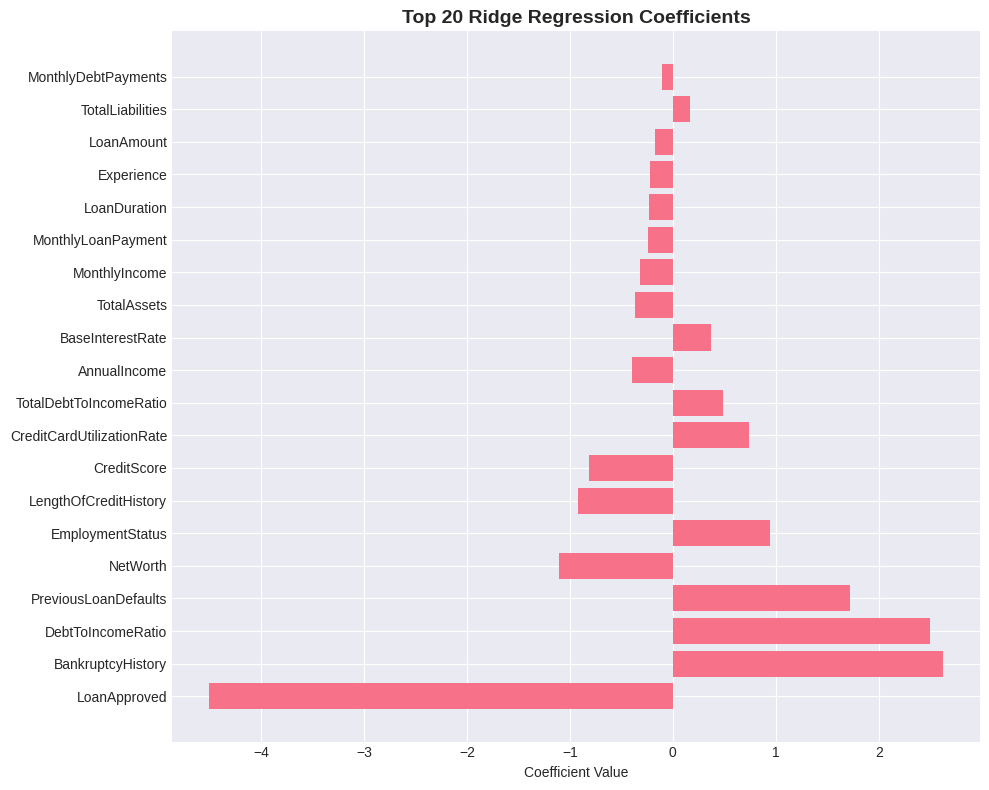

In [16]:
# Visualize Ridge coefficients
ridge_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_best.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(ridge_coef['Feature'], ridge_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Regression Coefficients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 2: Random Forest Regressor

In [ ]:
print("Training Random Forest Regressor...")

# Hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=R_seed, n_jobs=-1)
rf_random = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=30,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=R_seed,
    verbose=1
)

rf_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV RMSE: {-rf_random.best_score_:.4f}")

# Evaluate on all sets
rf_best = rf_random.best_estimator_
rf_metrics = evaluate_model(
    rf_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'Random Forest'
)
all_results.append(rf_metrics)

Training Random Forest Regressor...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
✅ Best CV RMSE: 1.7724

✅ Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
✅ Best CV RMSE: 1.7724

Random Forest - Performance Metrics

Training Set:
  RMSE: 0.6393
  MAE:  0.4745
  R²:   0.9932

Validation Set:
  RMSE: 1.6867
  MAE:  1.2629
  R²:   0.9528

Test Set:
  RMSE: 1.7000
  MAE:  1.2669
  R²:   0.9535

Random Forest - Performance Metrics

Training Set:
  RMSE: 0.6393
  MAE:  0.4745
  R²:   0.9932

Validation Set:
  RMSE: 1.6867
  MAE:  1.2629
  R²:   0.9528

Test Set:
  RMSE: 1.7000
  MAE:  1.2669
  R²:   0.9535


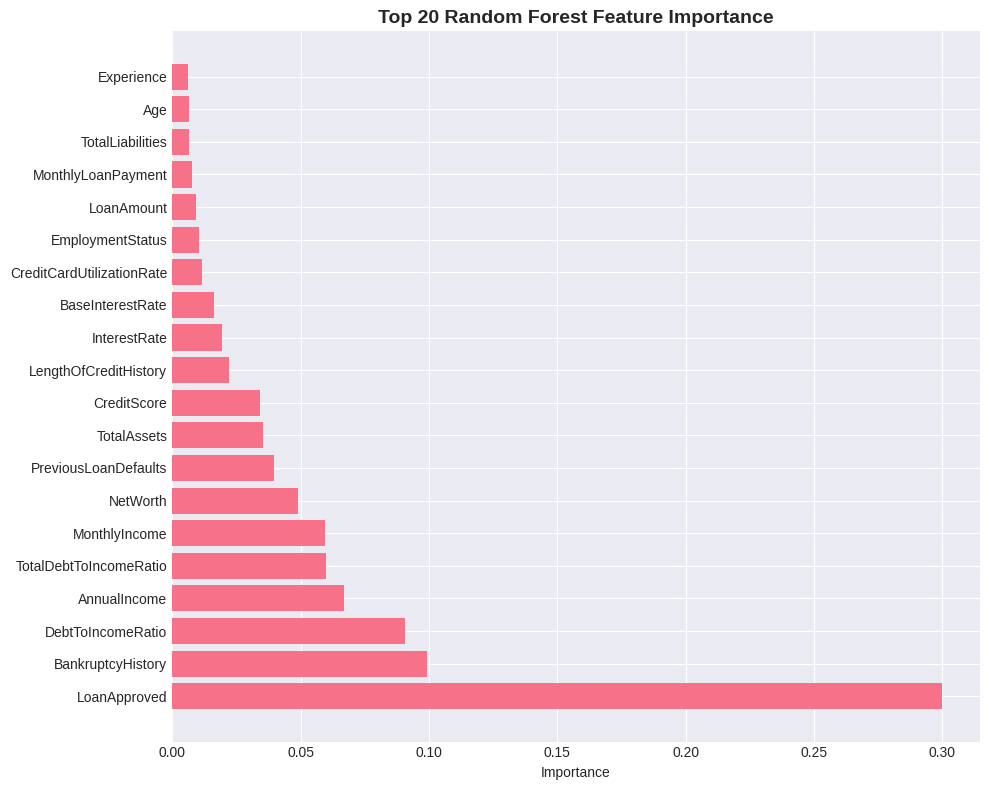

In [22]:
# Feature importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'], rf_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 3: XGBoost Regressor

In [ ]:
print("Training XGBoost Regressor...")

# Hyperparameter tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(
    random_state=R_seed,
    n_jobs=-1,
    tree_method='hist'
)

xgb_random = RandomizedSearchCV(
    xgb_model, 
    xgb_params, 
    n_iter=30,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=R_seed,
    verbose=1
)

xgb_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV RMSE: {-xgb_random.best_score_:.4f}")

# Evaluate on all sets
xgb_best = xgb_random.best_estimator_
xgb_metrics = evaluate_model(
    xgb_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'XGBoost'
)
all_results.append(xgb_metrics)

Training XGBoost Regressor...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
✅ Best CV RMSE: 0.3933

XGBoost - Performance Metrics

Training Set:
  RMSE: 0.2133
  MAE:  0.1431
  R²:   0.9992

Validation Set:
  RMSE: 0.3680
  MAE:  0.2187
  R²:   0.9978

Test Set:
  RMSE: 0.3548
  MAE:  0.2122
  R²:   0.9980

✅ Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
✅ Best CV RMSE: 0.3933

XGBoost - Performance Metrics

Training Set:
  RMSE: 0.2133
  MAE:  0.1431
  R²:   0.9992

Validation Set:
  RMSE: 0.3680
  MAE:  0.2187
  R²:   0.9978

Test Set:
  RMSE: 0.3548
  MAE:  0.2122
  R²:   0.9980


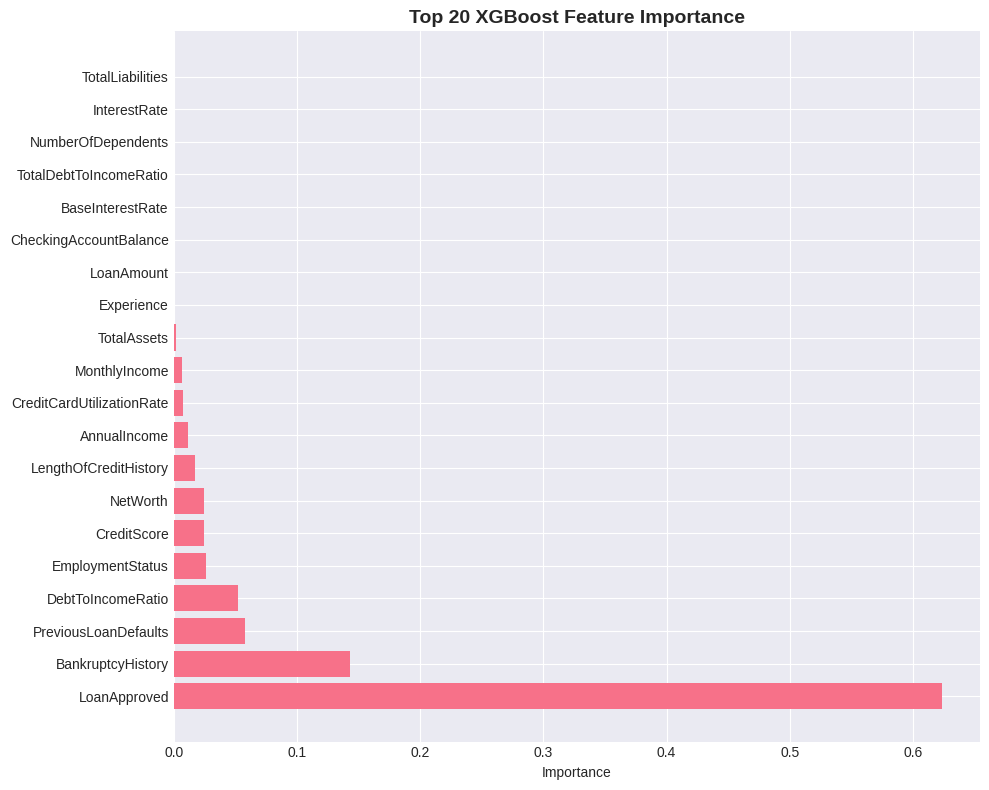

In [24]:
# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 4: CatBoost Regressor

In [ ]:
print("Training CatBoost Regressor...")

# Hyperparameter tuning
catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}

catboost_model = CatBoostRegressor(
    random_state=R_seed,
    verbose=0,
    thread_count=-1
)

catboost_random = RandomizedSearchCV(
    catboost_model, 
    catboost_params, 
    n_iter=20,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # CatBoost handles parallelization internally
    random_state=R_seed,
    verbose=1
)

catboost_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {catboost_random.best_params_}")
print(f"Best CV RMSE: {-catboost_random.best_score_:.4f}")

# Evaluate on all sets
catboost_best = catboost_random.best_estimator_
catboost_metrics = evaluate_model(
    catboost_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'CatBoost'
)
all_results.append(catboost_metrics)

Training CatBoost Regressor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
✅ Best CV RMSE: 0.2909

CatBoost - Performance Metrics

Training Set:
  RMSE: 0.1940
  MAE:  0.1190
  R²:   0.9994

Validation Set:
  RMSE: 0.2497
  MAE:  0.1412
  R²:   0.9990

Test Set:
  RMSE: 0.2363
  MAE:  0.1336
  R²:   0.9991

✅ Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
✅ Best CV RMSE: 0.2909

CatBoost - Performance Metrics

Training Set:
  RMSE: 0.1940
  MAE:  0.1190
  R²:   0.9994

Validation Set:
  RMSE: 0.2497
  MAE:  0.1412
  R²:   0.9990

Test Set:
  RMSE: 0.2363
  MAE:  0.1336
  R²:   0.9991


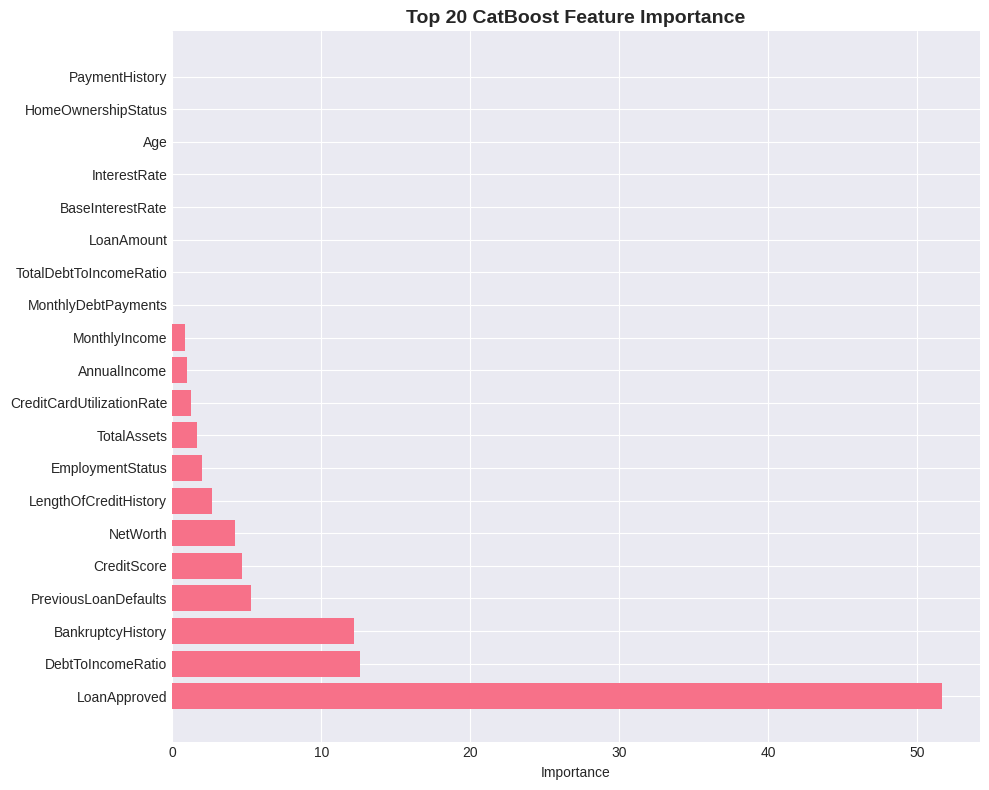

In [26]:
# Feature importance
catboost_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(catboost_importance['Feature'], catboost_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Results Comparison and Analysis

In [ ]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)


COMPREHENSIVE MODEL COMPARISON
           Model  Train_RMSE  Train_MAE  Train_R2  Val_RMSE  Val_MAE   Val_R2  Test_RMSE  Test_MAE  Test_R2
Ridge Regression    1.946907   1.510742  0.936848  1.881690 1.490657 0.941250   2.010076  1.532577 0.934924
Lasso Regression    1.947706   1.511735  0.936796  1.883052 1.492807 0.941165   2.009891  1.532591 0.934936
   Decision Tree    0.829514   0.510916  0.988536  1.387629 0.866159 0.968051   1.370448  0.851510 0.969750
   Random Forest    0.639258   0.474533  0.993192  1.686731 1.262852 0.952794   1.700008  1.266856 0.953452
         XGBoost    0.213251   0.143076  0.999242  0.367961 0.218685 0.997753   0.354825  0.212216 0.997972
        CatBoost    0.193969   0.118990  0.999373  0.249735 0.141168 0.998965   0.236315  0.133554 0.999101
          1D CNN    5.500662   4.363660  0.495887  5.626266 4.436187 0.474770   5.601540  4.402910 0.494628


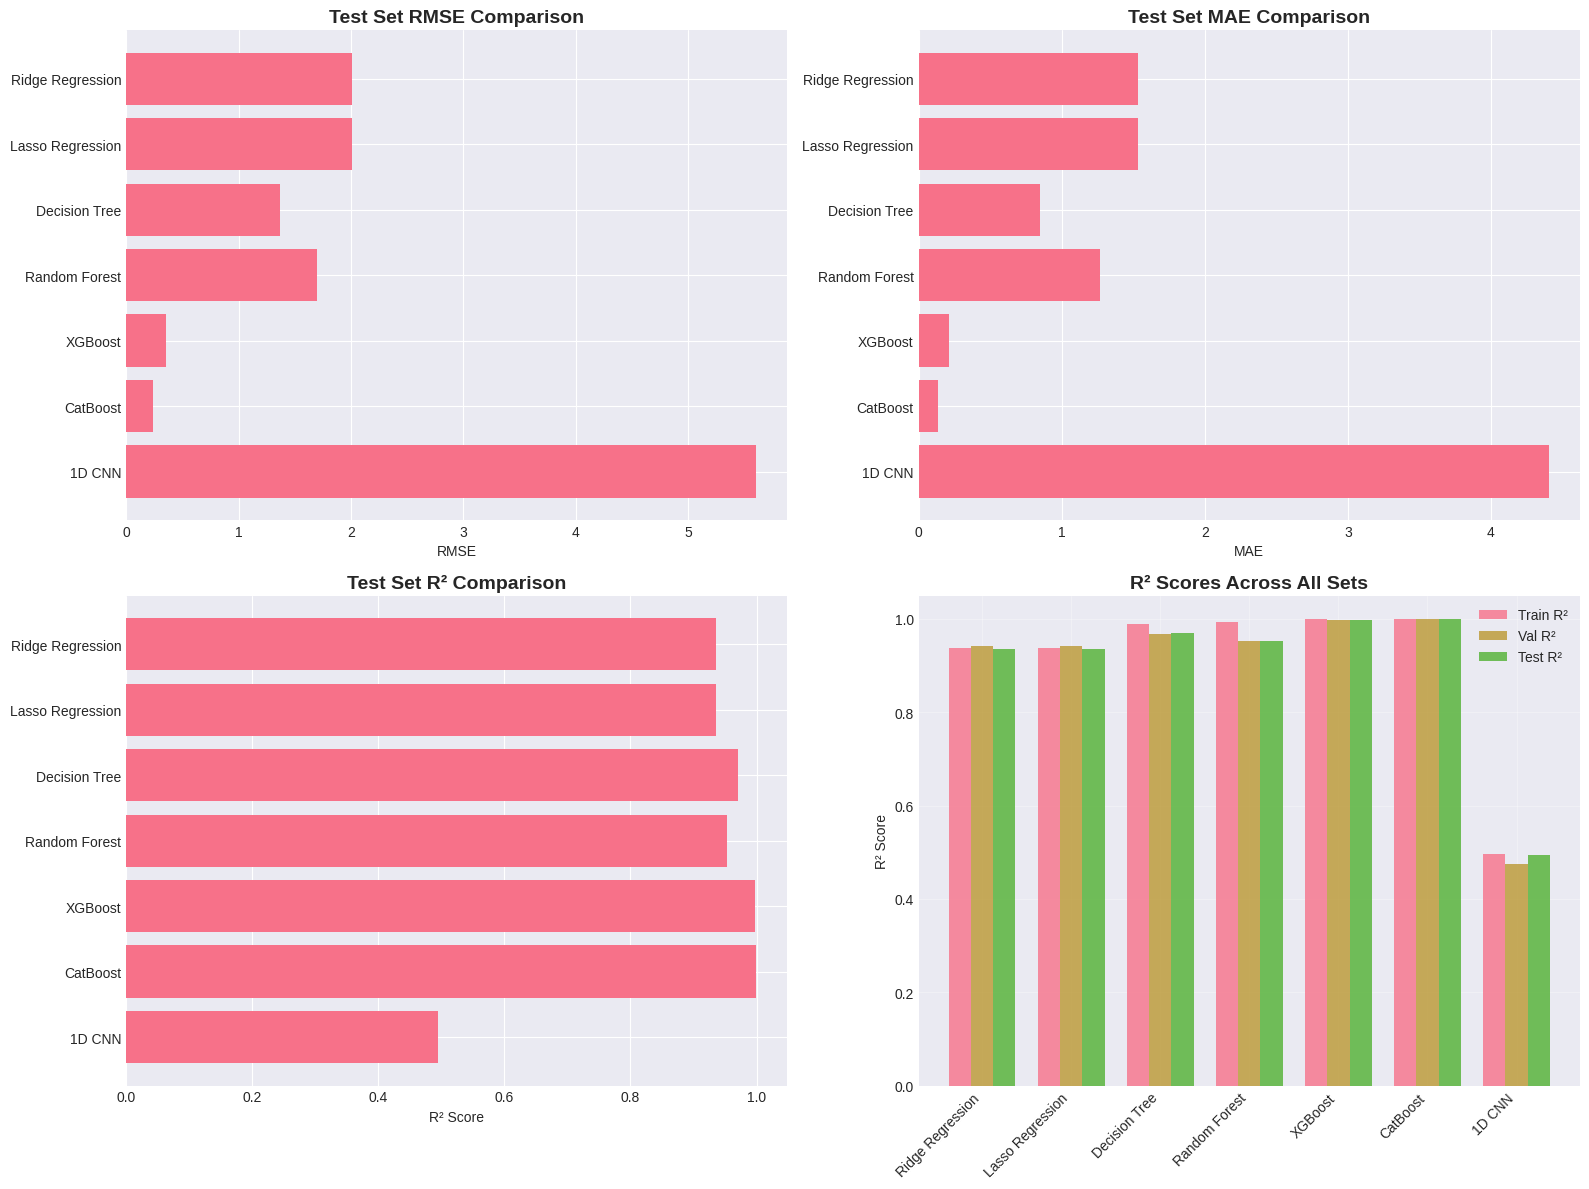

In [32]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE
axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test Set RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Test MAE
axes[0, 1].barh(results_df['Model'], results_df['Test_MAE'])
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Test Set MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Test R²
axes[1, 0].barh(results_df['Model'], results_df['Test_R2'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Test Set R² Comparison', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# All metrics comparison
x = np.arange(len(results_df))
width = 0.25
axes[1, 1].bar(x - width, results_df['Train_R2'], width, label='Train R²', alpha=0.8)
axes[1, 1].bar(x, results_df['Val_R2'], width, label='Val R²', alpha=0.8)
axes[1, 1].bar(x + width, results_df['Test_R2'], width, label='Test R²', alpha=0.8)
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('R² Scores Across All Sets', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Identify best model
best_model_idx = results_df['Test_RMSE'].idxmin()
best_model = results_df.loc[best_model_idx]

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Model: {best_model['Model']}")
print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")
print(f"Test MAE: {best_model['Test_MAE']:.4f}")
print(f"Test R²: {best_model['Test_R2']:.4f}")
print("="*80)


🏆 BEST MODEL
Model: CatBoost
Test RMSE: 0.2363
Test MAE: 0.1336
Test R²: 0.9991


In [34]:
# Check for overfitting
results_df['Train_Val_RMSE_Diff'] = results_df['Train_RMSE'] - results_df['Val_RMSE']
results_df['Train_Test_RMSE_Diff'] = results_df['Train_RMSE'] - results_df['Test_RMSE']

print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)
print("\nRMSE Differences (negative means worse on train):")
print(results_df[['Model', 'Train_Val_RMSE_Diff', 'Train_Test_RMSE_Diff']].to_string(index=False))
print("\nNote: Large positive differences indicate potential overfitting")
print("="*80)


OVERFITTING ANALYSIS

RMSE Differences (negative means worse on train):
           Model  Train_Val_RMSE_Diff  Train_Test_RMSE_Diff
Ridge Regression             0.065217             -0.063170
Lasso Regression             0.064653             -0.062186
   Decision Tree            -0.558115             -0.540934
   Random Forest            -1.047472             -1.060750
         XGBoost            -0.154710             -0.141574
        CatBoost            -0.055766             -0.042346
          1D CNN            -0.125604             -0.100879

Note: Large positive differences indicate potential overfitting


## Conclusion and Recommendations

In [ ]:
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print(f"\n1. Best Overall Model: {best_model['Model']}")
print(f"   - Achieves the lowest test RMSE: {best_model['Test_RMSE']:.4f}")
print(f"   - R² Score: {best_model['Test_R2']:.4f}")

print("\n2. Model Rankings by Test RMSE:")
rankings = results_df.sort_values('Test_RMSE')[['Model', 'Test_RMSE', 'Test_R2']]
for idx, (_, row) in enumerate(rankings.iterrows(), 1):
    print(f"   {idx}. {row['Model']:20s} - RMSE: {row['Test_RMSE']:.4f}, R²: {row['Test_R2']:.4f}")

print("\n3. Key Insights:")
print("   - Tree-based models (RF, XGBoost, CatBoost) generally perform well")
print("   - Linear models (Ridge, Lasso) provide interpretability but may underperform")
print("   - Deep learning (CNN) requires more data for optimal performance")

print("\n4. Recommendations for Deployment:")
print(f"   - Use {best_model['Model']} for production")
print("   - Monitor model performance regularly")
print("   - Consider ensemble methods combining top models")
print("   - Implement feature engineering for further improvement")

print("\n5. Future Improvements:")
print("   - Feature engineering (interactions, polynomials)")
print("   - More advanced hyperparameter optimization (Bayesian)")
print("   - Ensemble methods (stacking, blending)")
print("   - Feature selection techniques")
print("   - Handle imbalanced data if present")
print("="*80)


📊 SUMMARY AND RECOMMENDATIONS

1. Best Overall Model: CatBoost
   - Achieves the lowest test RMSE: 0.2363
   - R² Score: 0.9991

2. Model Rankings by Test RMSE:
   1. CatBoost             - RMSE: 0.2363, R²: 0.9991
   2. XGBoost              - RMSE: 0.3548, R²: 0.9980
   3. Decision Tree        - RMSE: 1.3704, R²: 0.9698
   4. Random Forest        - RMSE: 1.7000, R²: 0.9535
   5. Lasso Regression     - RMSE: 2.0099, R²: 0.9349
   6. Ridge Regression     - RMSE: 2.0101, R²: 0.9349
   7. 1D CNN               - RMSE: 5.6015, R²: 0.4946

3. Key Insights:
   - Tree-based models (RF, XGBoost, CatBoost) generally perform well
   - Linear models (Ridge, Lasso) provide interpretability but may underperform
   - Deep learning (CNN) requires more data for optimal performance

4. Recommendations for Deployment:
   - Use CatBoost for production
   - Monitor model performance regularly
   - Consider ensemble methods combining top models
   - Implement feature engineering for further improvement

5.

In [ ]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")


✅ Results saved to 'model_comparison_results.csv'
